In [1]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import quad
from online_cp.CPS import NearestNeighboursPredictionMachine
from online_cp import PluginMartingale
from ucimlrepo import fetch_ucirepo 
from scipy.stats import beta

In [2]:
def compute_CPRS(pred_dist, y_true, yrange, tau):
    # Compute CDF and normalize
    cdf_values = np.array([pred_dist(y, tau) for y in yrange])

    # Observed value
    x_obs = y_true

    # Compute CRPS
    indicator = np.where(yrange >= x_obs, 1, 0)  # Heaviside function
    differences = cdf_values - indicator
    dx = np.diff(yrange)

    crps = np.sum((differences[:-1] ** 2) * dx)

    return crps

# IID

In [3]:
N = 1000
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))

coeff = np.array([20, 1, 0, 0])
Y = X @ coeff + rnd_gen.normal(loc=0, scale=1, size=N)

X_train = X[:int(N/4)]
y_train = Y[:int(N/4)]

X_test = X[int(N/4):]
y_test = Y[int(N/4):]

In [4]:
cps = NearestNeighboursPredictionMachine(k=19)

martingale = PluginMartingale(warnings=False)

calibration_martingale = PluginMartingale(warnings=False)

cps.learn_initial_training_set(X_train, y_train)

Base_loss = 0
Protected_loss = 0

cum_loss = np.zeros(shape=(y_test.shape[0], 2))

for i, (object, label) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Running protected CPS'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use

    # Apply protection
    protected_cpd = lambda y, tau: martingale.B_n(cpd(y, tau))

    # Reality outputs label
    # Compute loss
    yrange = np.linspace(cpd.Y[1:-1].min() - 1, cpd.Y[1:-1].max() + 1, num=100, endpoint=True)
    base_loss = compute_CPRS(cpd, label, yrange, tau)
    protected_loss = compute_CPRS(protected_cpd, label, yrange, tau)

    Base_loss += base_loss
    Protected_loss += protected_loss

    cum_loss[i, 0] = Base_loss
    cum_loss[i, 1] = Protected_loss

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_martingale_value(cpd(y=label, tau=tau))

    calibration_martingale.update_martingale_value(protected_cpd(y=label, tau=tau))

Running protected CPS:   0%|          | 0/750 [00:00<?, ?it/s]

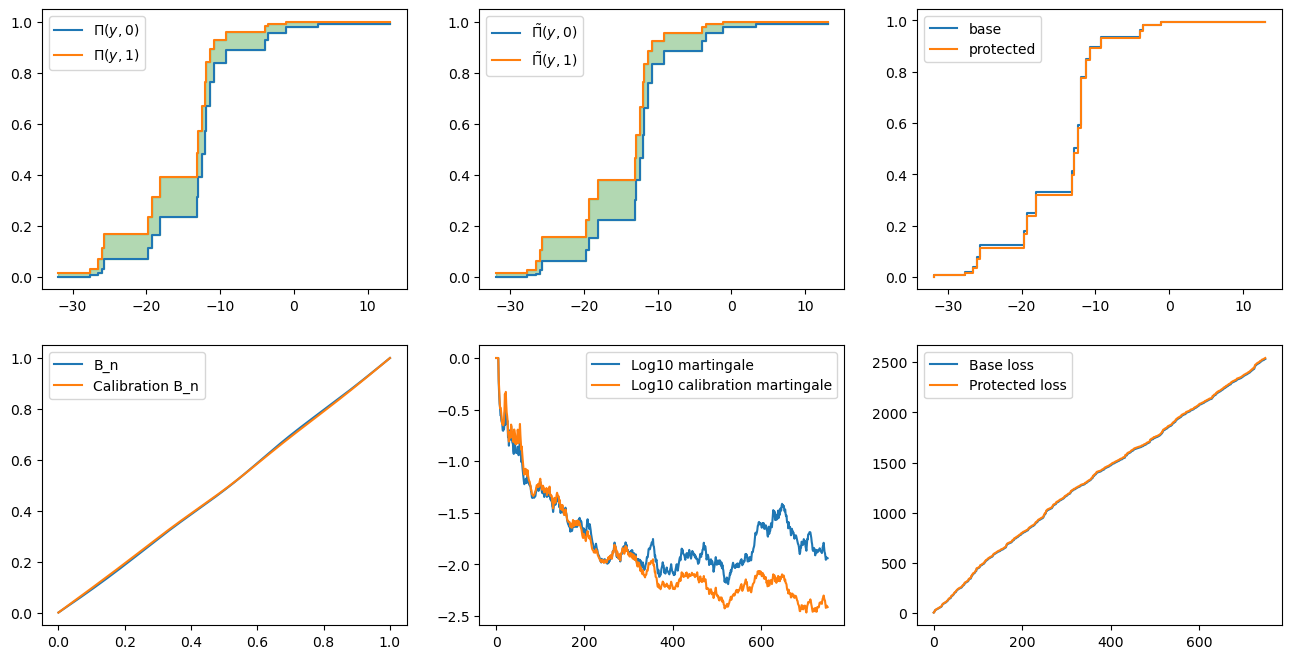

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    where='post',
    label=r'$\Pi(y, 0)$'
)
axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\Pi(y, 1)$'
)

# Use fill_between for the area between the two step functions
axs[0, 0].fill_between(
    cpd.Y[1:-1],
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    [cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 0].legend()


axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 0)$'
)
axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 1)$'
)
axs[0, 1].fill_between(
    cpd.Y[1:-1],
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 1].legend()

axs[0, 2].step(
    cpd.Y[1:-1], 
    [cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='base'
)
axs[0, 2].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='protected'
)
axs[0, 2].legend()

prange = np.linspace(0, 1, num=1000)
axs[1, 0].plot(
    prange,
    martingale.B_n(prange),
    label=r'B_n'
)
axs[1, 0].plot(
    prange,
    calibration_martingale.B_n(prange),
    label=r'Calibration B_n'
)
axs[1, 0].legend()


axs[1, 1].plot(martingale.log10_martingale_values, label='Log10 martingale')
axs[1, 1].plot(calibration_martingale.log10_martingale_values, label='Log10 calibration martingale')
axs[1, 1].legend()

axs[1, 2].plot(cum_loss, label=['Base loss', 'Protected loss'])
axs[1, 2].legend()

In [6]:
print(f'Loss CPS: {Base_loss}')
print(f'Loss protected CPS: {Protected_loss}')
print(f'Improvement: {1 - Protected_loss / Base_loss}')

Loss CPS: 2532.9984937016775
Loss protected CPS: 2542.5455390671364
Improvement: -0.0037690687101463727


# Change point

In [7]:
coeff1 = np.array([20, 1, 0, 0])
coeff2 = np.array([0, 0, 1, 20])

Y1 = X[:int(N/2)] @ coeff1 + rnd_gen.normal(loc=0, scale=1, size=int(N/2))
Y2 = X[int(N/2):N] @ coeff2 + rnd_gen.normal(loc=0.5, scale=1, size=int(N/2))
Y = np.concatenate([Y1, Y2])

X_train = X[:int(N/4)]
y_train = Y[:int(N/4)]

X_test = X[int(N/4):]
y_test = Y[int(N/4):]

In [8]:
cps = NearestNeighboursPredictionMachine(k=19)

martingale = PluginMartingale(warnings=False)

calibration_martingale = PluginMartingale(warnings=False)

cps.learn_initial_training_set(X_train, y_train)

Base_loss = 0
Protected_loss = 0

cum_loss = np.zeros(shape=(y_test.shape[0], 2))

for i, (object, label) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Running protected CPS'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use

    # Apply protection
    protected_cpd = lambda y, tau: martingale.B_n(cpd(y, tau))

    # Reality outputs label
    # Compute loss
    yrange = np.linspace(cpd.Y[1:-1].min() - 1, cpd.Y[1:-1].max() + 1, num=100, endpoint=True)
    base_loss = compute_CPRS(cpd, label, yrange, tau)
    protected_loss = compute_CPRS(protected_cpd, label, yrange, tau)

    Base_loss += base_loss
    Protected_loss += protected_loss

    cum_loss[i, 0] = Base_loss
    cum_loss[i, 1] = Protected_loss

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_martingale_value(cpd(y=label, tau=tau))

    calibration_martingale.update_martingale_value(protected_cpd(y=label, tau=tau))

Running protected CPS:   0%|          | 0/750 [00:00<?, ?it/s]

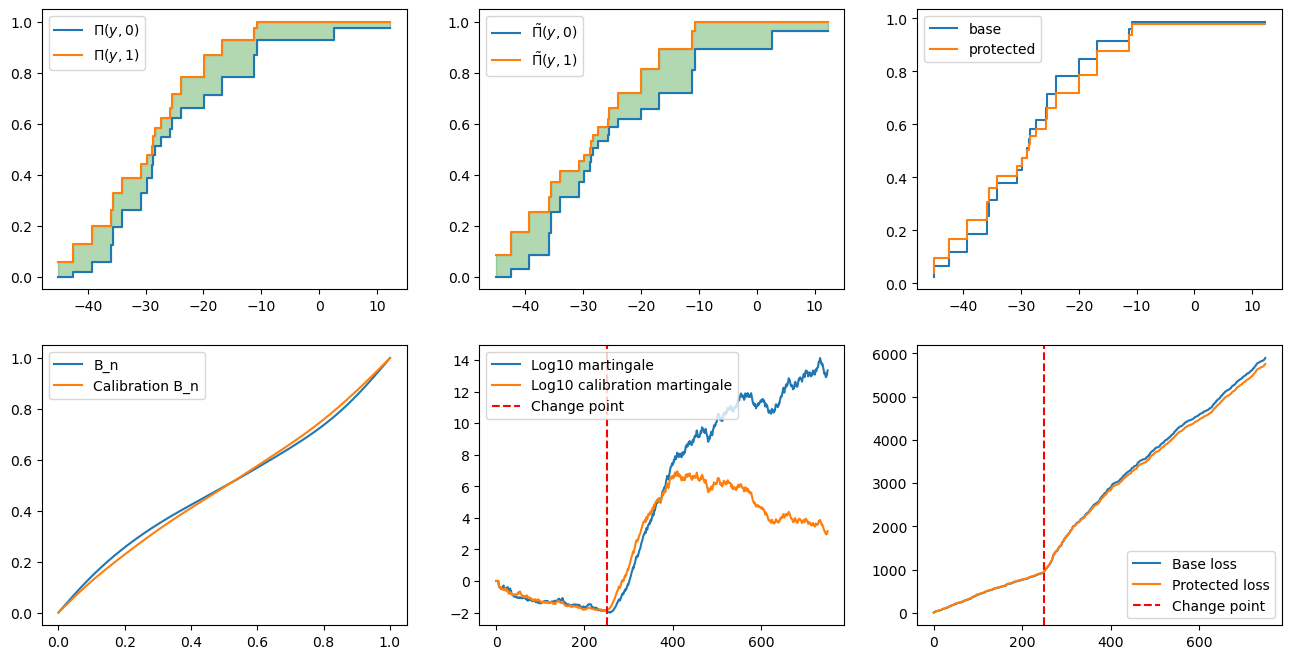

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    where='post',
    label=r'$\Pi(y, 0)$'
)
axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\Pi(y, 1)$'
)

# Use fill_between for the area between the two step functions
axs[0, 0].fill_between(
    cpd.Y[1:-1],
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    [cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 0].legend()


axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 0)$'
)
axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 1)$'
)
axs[0, 1].fill_between(
    cpd.Y[1:-1],
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 1].legend()

axs[0, 2].step(
    cpd.Y[1:-1], 
    [cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='base'
)
axs[0, 2].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='protected'
)
axs[0, 2].legend()

prange = np.linspace(0, 1, num=1000)
axs[1, 0].plot(
    prange,
    martingale.B_n(prange),
    label=r'B_n'
)
axs[1, 0].plot(
    prange,
    calibration_martingale.B_n(prange),
    label=r'Calibration B_n'
)
axs[1, 0].legend()


axs[1, 1].plot(martingale.log10_martingale_values, label='Log10 martingale')
axs[1, 1].plot(calibration_martingale.log10_martingale_values, label='Log10 calibration martingale')
axs[1, 1].axvline(N/4, linestyle='--', color='red', label='Change point')
axs[1, 1].legend()

axs[1, 2].plot(cum_loss, label=['Base loss', 'Protected loss'])
axs[1, 2].axvline(N/4, linestyle='--', color='red', label='Change point')
axs[1, 2].legend()

In [10]:
print(f'Loss CPS: {Base_loss}')
print(f'Loss protected CPS: {Protected_loss}')
print(f'Improvement: {1 - Protected_loss / Base_loss}')

Loss CPS: 5893.7449417964035
Loss protected CPS: 5755.890631696447
Improvement: 0.023389934831136272


# Real data: Wine dataset

In [32]:
wine_quality = fetch_ucirepo(id=186) 

X_test = wine_quality.data.original[wine_quality.data.original.color == 'red'].drop(columns=['quality', 'color'])
X_train = wine_quality.data.original[wine_quality.data.original.color == 'white'].drop(columns=['quality', 'color'])
y_test = wine_quality.data.original[wine_quality.data.original.color == 'red']['quality'].astype('float').values
y_train = wine_quality.data.original[wine_quality.data.original.color == 'white']['quality'].astype('float').values

In [33]:
# We cheat since we normalise everything beforehand...
X_test = ((X_test - X_test.mean()) / X_test.std()).values
X_train = ((X_train - X_train.mean()) / X_train.std()).values

# Also, our prediction algorithm requires all labels to be unique, so we add some Gaussian noise

# Ensure all labels are unique
noise_range = 1e-6
for y in [y_train, y_test]:
    while np.unique(y).shape[0] < y.shape[0]:
        # Find duplicates
        unique, counts = np.unique(y, return_counts=True)
        duplicates = unique[counts > 1]

        # Add noise to duplicate entries
        for label in duplicates:
            indices = np.where(y == label)[0]
            noise = rnd_gen.uniform(low=-noise_range, high=noise_range, size=len(indices))
            y[indices] += noise

Let's start with a reduced experiment

In [34]:
# We get 2*M examples
M = 200
X_train = X_train[:M]
y_train = y_train[:M]
X_test = X_test[:M]
y_test = y_test[:M]

# And now we want to see what happens at the change point, so this akward step is necessary...
X = np.concatenate([X_train, X_test])
Y = np.concatenate([y_train, y_test])
initial_training_size = int(M/2)
X_train = X[:initial_training_size]
y_train = Y[:initial_training_size]
X_test = X[initial_training_size:]
y_test = Y[initial_training_size:]

In [35]:
cps = NearestNeighboursPredictionMachine(k=3)

martingale = PluginMartingale(warnings=False, min_sample_size=10)

calibration_martingale = PluginMartingale(warnings=False, min_sample_size=10)

cps.learn_initial_training_set(X_train, y_train)

Base_loss = 0
Protected_loss = 0

cum_loss = np.zeros(shape=(y_test.shape[0], 2))

for i, (object, label) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Running protected CPS'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use

    # Apply protection
    protected_cpd = lambda y, tau: martingale.B_n(cpd(y, tau))

    # Reality outputs label
    # Compute loss
    yrange = np.linspace(cpd.Y[1:-1].min()-1, cpd.Y[1:-1].max()+1, num=100, endpoint=True)
    base_loss = compute_CPRS(cpd, label, yrange, tau)
    protected_loss = compute_CPRS(protected_cpd, label, yrange, tau)

    Base_loss += base_loss
    Protected_loss += protected_loss

    cum_loss[i, 0] = Base_loss
    cum_loss[i, 1] = Protected_loss

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_martingale_value(cpd(y=label, tau=tau))

    calibration_martingale.update_martingale_value(protected_cpd(y=label, tau=tau))

Running protected CPS:   0%|          | 0/300 [00:00<?, ?it/s]

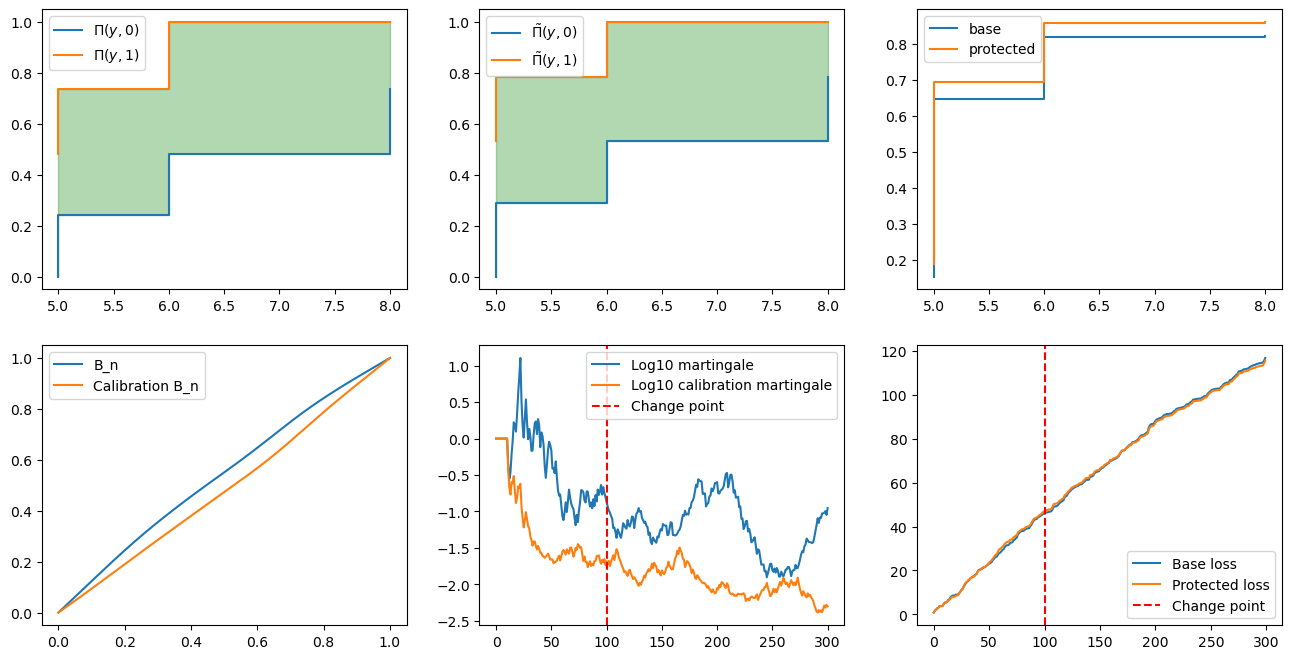

In [36]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    where='post',
    label=r'$\Pi(y, 0)$'
)
axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\Pi(y, 1)$'
)

# Use fill_between for the area between the two step functions
axs[0, 0].fill_between(
    cpd.Y[1:-1],
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    [cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 0].legend()


axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 0)$'
)
axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 1)$'
)
axs[0, 1].fill_between(
    cpd.Y[1:-1],
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 1].legend()

axs[0, 2].step(
    cpd.Y[1:-1], 
    [cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='base'
)
axs[0, 2].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='protected'
)
axs[0, 2].legend()

prange = np.linspace(0, 1, num=1000)
axs[1, 0].plot(
    prange,
    martingale.B_n(prange),
    label=r'B_n'
)
axs[1, 0].plot(
    prange,
    calibration_martingale.B_n(prange),
    label=r'Calibration B_n'
)
axs[1, 0].legend()


axs[1, 1].plot(martingale.log10_martingale_values, label='Log10 martingale')
axs[1, 1].plot(calibration_martingale.log10_martingale_values, label='Log10 calibration martingale')
axs[1, 1].axvline(M/2, linestyle='--', color='red', label='Change point')
axs[1, 1].legend()

axs[1, 2].plot(cum_loss, label=['Base loss', 'Protected loss'])
axs[1, 2].axvline(M/2, linestyle='--', color='red', label='Change point')
axs[1, 2].legend()

In [37]:
print(f'Loss CPS: {Base_loss}')
print(f'Loss protected CPS: {Protected_loss}')
print(f'Improvement: {1 - Protected_loss / Base_loss}')

Loss CPS: 116.75308730882978
Loss protected CPS: 115.44770690854149
Improvement: 0.011180692779757972


# Real data: Concrete Compressive Strength

In [49]:
# fetch dataset Concrete Compressive Strength
concrete_compressive_strength = fetch_ucirepo(id=165) 
  
# data (as pandas dataframes) 
X = concrete_compressive_strength.data.features.astype('float')
Y = concrete_compressive_strength.data.targets.astype('float')

In [51]:
N = 50000
X = (X - X.mean()) / X.std()
X = X.values[:N]
Y = Y.values.flatten()[:N]

# Ensure all labels are unique
noise_range = 1e-6
while np.unique(Y).shape[0] < Y.shape[0]:
    # Find duplicates
    unique, counts = np.unique(Y, return_counts=True)
    duplicates = unique[counts > 1]

    # Add noise to duplicate entries
    for label in duplicates:
        indices = np.where(Y == label)[0]
        noise = rnd_gen.uniform(low=-noise_range, high=noise_range, size=len(indices))
        Y[indices] += noise

In [53]:
initial_training_size = 100
X_train = X[:initial_training_size]
y_train = Y[:initial_training_size]
X_test = X[initial_training_size:]
y_test = Y[initial_training_size:]

In [54]:
cps = NearestNeighboursPredictionMachine(k=3)

martingale = PluginMartingale(warnings=False)

calibration_martingale = PluginMartingale(warnings=False)

cps.learn_initial_training_set(X_train, y_train)

Base_loss = 0
Protected_loss = 0

cum_loss = np.zeros(shape=(y_test.shape[0], 2))

for i, (object, label) in tqdm(enumerate(zip(X_test, y_test)), total=y_test.shape[0], desc='Running protected CPS'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use

    # Apply protection
    protected_cpd = lambda y, tau: martingale.B_n(cpd(y, tau))
    
    # Reality outputs label
    # Compute loss
    yrange = np.linspace(cpd.Y[1:-1].min()-1, cpd.Y[1:-1].max()+1, num=100, endpoint=True)
    base_loss = compute_CPRS(cpd, label, yrange, tau)
    protected_loss = compute_CPRS(protected_cpd, label, yrange, tau)

    Base_loss += base_loss
    Protected_loss += protected_loss

    cum_loss[i, 0] = Base_loss
    cum_loss[i, 1] = Protected_loss

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Update martingale
    martingale.update_martingale_value(cpd(y=label, tau=tau))

    calibration_martingale.update_martingale_value(protected_cpd(y=label, tau=tau))

Running protected CPS:   0%|          | 0/930 [00:00<?, ?it/s]

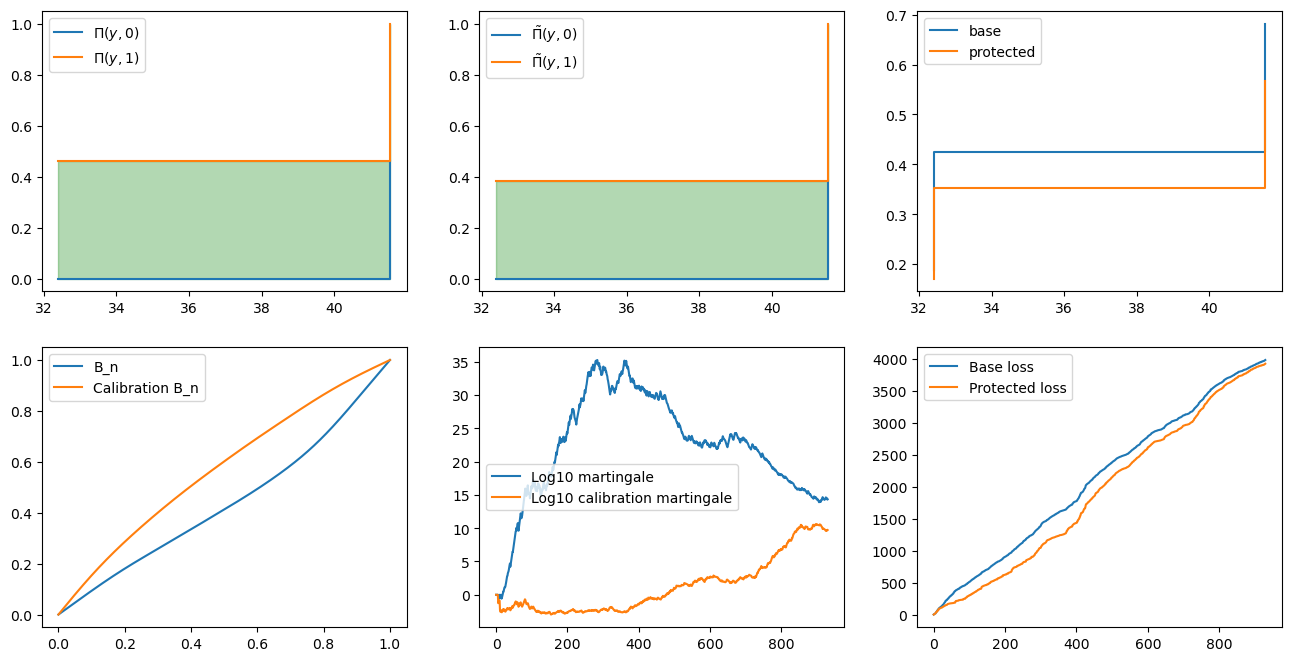

In [65]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    where='post',
    label=r'$\Pi(y, 0)$'
)
axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\Pi(y, 1)$'
)

# Use fill_between for the area between the two step functions
axs[0, 0].fill_between(
    cpd.Y[1:-1],
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    [cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 0].legend()


axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 0)$'
)
axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 1)$'
)
axs[0, 1].fill_between(
    cpd.Y[1:-1],
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 1].legend()

axs[0, 2].step(
    cpd.Y[1:-1], 
    [cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='base'
)
axs[0, 2].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='protected'
)
axs[0, 2].legend()

prange = np.linspace(0, 1, num=1000)
axs[1, 0].plot(
    prange,
    martingale.B_n(prange),
    label=r'B_n'
)
axs[1, 0].plot(
    prange,
    calibration_martingale.B_n(prange),
    label=r'Calibration B_n'
)
axs[1, 0].legend()


axs[1, 1].plot(martingale.log10_martingale_values, label='Log10 martingale')
axs[1, 1].plot(calibration_martingale.log10_martingale_values, label='Log10 calibration martingale')
axs[1, 1].legend()

axs[1, 2].plot(cum_loss, label=['Base loss', 'Protected loss'])
axs[1, 2].legend()

In [57]:
print(f'CRPS Loss CPS: {Base_loss}')
print(f'CRPS Loss protected CPS: {Protected_loss}')
print(f'CRPS Improvement: {1 - Protected_loss / Base_loss}')

CRPS Loss CPS: 3977.7377162394037
CRPS Loss protected CPS: 3919.4792495750676
CRPS Improvement: 0.014646130745748165


# Conclusions
Protection sort of works, in the sense that the calibration martingale (probability integral transform (PIT) of the protected distribution) is consistently lower than the test martingale (PIT of base distribution). This does not necessarily, however, translate to lower CRPS losses. This may be because my implementation is wrong, or it may simply not make that much difference.

### Theoretical questions
* Is the protected CPS still a conformal predictive system? - NO, it is not a conformal transducer.
* If not, is it a randomised predictive system? - YES, and it is easy to prove.
* Is the calibration martingale a reasonable calibration metric?
* Game-theoretic treatment of the probability integral transformation, see [Dawid and Vovk. Prequential probability: Principles and properties. Bernoulli, 5:125–162, 1999, Theorem 2(b)]. (Stated as interesting in the paper)

### Practical questions
* What are some reasonable evaluation metrics apart from CRPS?
* Is my CRPS correct? Can it even be used for RPS? It is not a proper CDF.
* Try the protection with some other martingale!

# Possible paper
If protected CPS is new and interesting, there should be a paper on this. Would Volodya be interested? Or Ilia? Or Alex?

Paper should include
* Theory
* Synthetic data
* At least two test martingales
* At least two different CPS (Possibly Dempster-Hill for a situation with only labels)
* A real dataset (e.g. Wine)

It is also interesting to test different plug-in estimators. Perhaps a separate paper, or a subsection? We could try the same experiments as Plugin paper by Vovk et al.

# Electricity
Does not really work that well...

In [66]:
import pandas as pd
MACHINE_EPSILON = lambda x: np.abs(x) * np.finfo(np.float64).eps

D = 24
Winter = pd.read_csv('Winter.csv', parse_dates=True, index_col='Time')
Winter = Winter.asfreq('h')
Winter24 = Winter['2024-01-01':'2024-02-01']
data = Winter24[
    [
        'demand', # The demand now
        'temperature', # The tempereature now
        f'Hour_{D}', # We always know what hour it will be in 24 hours
    ]]
initial_training_set_size = 2*D

data = (data - data.min()) / (data.max() - data.min())

knonw_initially = data[:initial_training_set_size]
future = data[initial_training_set_size:]

X_initial_train = knonw_initially[['temperature', f'Hour_{D}']]
y_initial_train = knonw_initially.demand

In [68]:
cps = NearestNeighboursPredictionMachine(k=3)

martingale = PluginMartingale(warnings=False, min_sample_size=25)

calibration_martingale = PluginMartingale(warnings=False, min_sample_size=25)

cps.learn_initial_training_set(X_initial_train.values, y_initial_train.values)

Base_loss = 0
Protected_loss = 0

cum_loss = np.zeros(shape=(future.shape[0], 2))

j = 0
for i, obj in tqdm(future.iterrows(), total=future.shape[0], desc=f'Electricity'):
    # This is all we know now
    known = data[data.index <= i]

    # Reality outputs object and a random number tau
    x = obj[['temperature', f'Hour_{D}']].values
    tau = rnd_gen.uniform(0, 1)    

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=x, return_update=True) # We return the precomputed update for later use

    # Apply protection
    protected_cpd = lambda y, tau: martingale.B_n(cpd(y, tau))
    
    # Reality outputs label
    y = obj.demand
    # Compute loss
    try:
        finite_mask = np.isfinite(cpd.Y)
        Y_finite = cpd.Y[finite_mask]
        min = Y_finite.min() - 1
        max = Y_finite.max() + 1
        yrange = np.linspace(min, max, num=100, endpoint=True)
        base_loss = compute_CPRS(cpd, y, yrange, tau)
        protected_loss = compute_CPRS(protected_cpd, y, yrange, tau)

        Base_loss += base_loss
        Protected_loss += protected_loss
    except Exception as e:
        print(e)

    cum_loss[j, 0] = Base_loss
    cum_loss[j, 1] = Protected_loss

    # Learn new example
    cps.learn_one(x, y)

    # Update martingale
    martingale.update_martingale_value(cpd(y=y, tau=tau))

    calibration_martingale.update_martingale_value(protected_cpd(y=y, tau=tau))

    j += 1

Electricity:   0%|          | 0/720 [00:00<?, ?it/s]

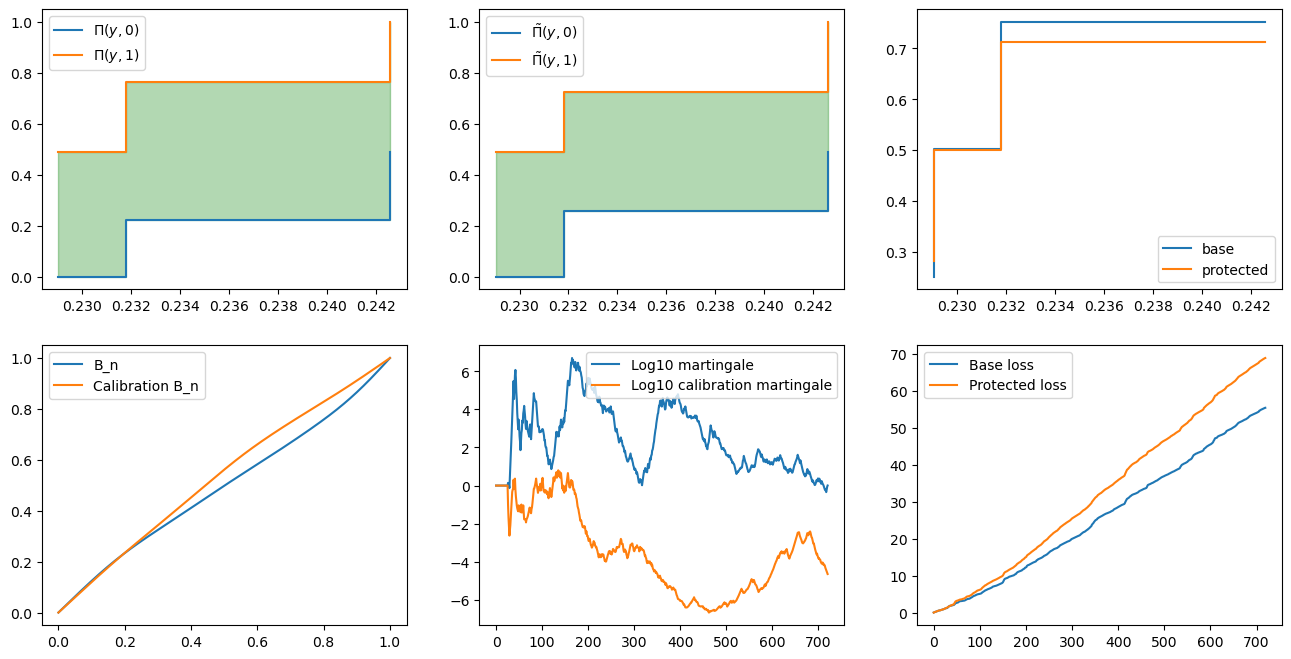

In [69]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16,8))

axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    where='post',
    label=r'$\Pi(y, 0)$'
)
axs[0, 0].step(
    cpd.Y[1:-1], 
    [cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\Pi(y, 1)$'
)

# Use fill_between for the area between the two step functions
axs[0, 0].fill_between(
    cpd.Y[1:-1],
    [cpd(y, 0) for y in cpd.Y[1:-1]], 
    [cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 0].legend()


axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 0)$'
)
axs[0, 1].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]],
    where='post',
    label=r'$\tilde{\Pi}(y, 1)$'
)
axs[0, 1].fill_between(
    cpd.Y[1:-1],
    [protected_cpd(y, 0) for y in cpd.Y[1:-1]], 
    [protected_cpd(y, 1) for y in cpd.Y[1:-1]], 
    step='post', 
    color='green', 
    alpha=0.3, 
)
axs[0, 1].legend()

axs[0, 2].step(
    cpd.Y[1:-1], 
    [cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='base'
)
axs[0, 2].step(
    cpd.Y[1:-1], 
    [protected_cpd(y, tau) for y in cpd.Y[1:-1]], 
    label='protected'
)
axs[0, 2].legend()

prange = np.linspace(0, 1, num=1000)
axs[1, 0].plot(
    prange,
    martingale.B_n(prange),
    label=r'B_n'
)
axs[1, 0].plot(
    prange,
    calibration_martingale.B_n(prange),
    label=r'Calibration B_n'
)
axs[1, 0].legend()


axs[1, 1].plot(martingale.log10_martingale_values, label='Log10 martingale')
axs[1, 1].plot(calibration_martingale.log10_martingale_values, label='Log10 calibration martingale')
axs[1, 1].legend()

axs[1, 2].plot(cum_loss, label=['Base loss', 'Protected loss'])
axs[1, 2].legend()

In [70]:
print(f'CRPS Loss CPS: {Base_loss}')
print(f'CRPS Loss protected CPS: {Protected_loss}')
print(f'CRPS Improvement: {1 - Protected_loss / Base_loss}')

CRPS Loss CPS: 55.41214270190131
CRPS Loss protected CPS: 68.85893062598021
CRPS Improvement: -0.24266861500769044


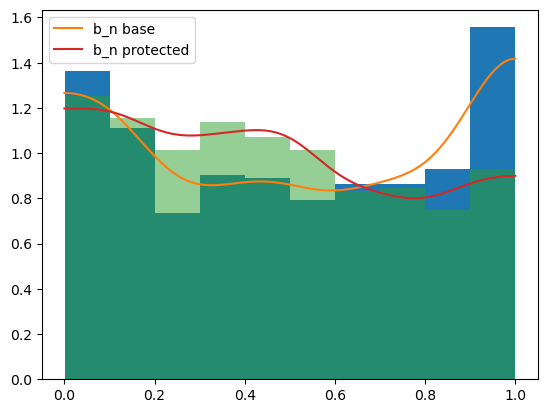

In [74]:
plt.hist(martingale.p_values, density=True)
plt.plot(
    prange,
    martingale.b_n(prange),
    label=r'b_n base'
)

plt.hist(calibration_martingale.p_values, density=True, alpha=0.5)
plt.plot(
    prange,
    calibration_martingale.b_n(prange),
    label=r'b_n protected'
)
plt.legend()